In [1]:
import librosa 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import IPython.display as ipd 
import os,shutil
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip, concatenate_videoclips

In [7]:
SAMPLES_DIR="../samples/"
ETC_DIR=SAMPLES_DIR+"etc/"
AUDIO_DIR=SAMPLES_DIR+"audio/"
OUT_DIR=SAMPLES_DIR+"out/"
VIDEO_NAME="Untitled.mp4"
AUDIO_NAME="Untitled.wav"

In [20]:
from pydub import AudioSegment

video = AudioSegment.from_file(SAMPLES_DIR+VIDEO_NAME, format="mp4")

In [21]:
audio = video.set_channels(1).set_frame_rate(16000).set_sample_width(2)

In [22]:
audio.export(AUDIO_DIR+AUDIO_NAME, format="wav")

<_io.BufferedRandom name='../samples/audio/videoplayback.wav'>

In [9]:
#Enter your audio file name of match here. .wav,.mp3, etc. are supported.
vid, sample_rate = librosa.load(AUDIO_DIR+AUDIO_NAME,sr=16000)
print(int(librosa.get_duration(y=vid, sr=sample_rate)/60))

KeyboardInterrupt: 

In [24]:
#Breaking down video into chunks of 5 seconds so that rise in energy can be found.
chunk_size=5 
window_length = chunk_size * sample_rate

2432.1703685363755


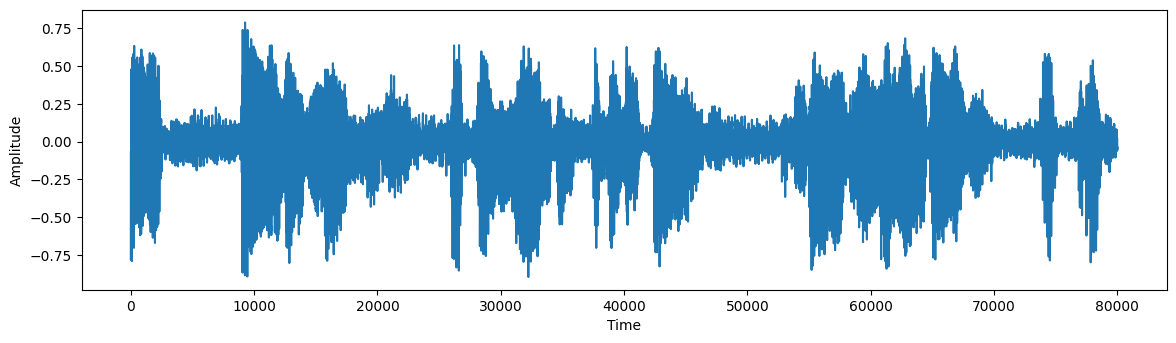

In [25]:
#seeing an audio sample and it's time-amplitude graph
a=vid[5*window_length:6*window_length] 
ipd.Audio(a, rate=sample_rate)
energy = sum(abs(a**2))
print(energy)
fig = plt.figure(figsize=(14, 8)) 
ax1 = fig.add_subplot(211) 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Amplitude') 
ax1.plot(a)

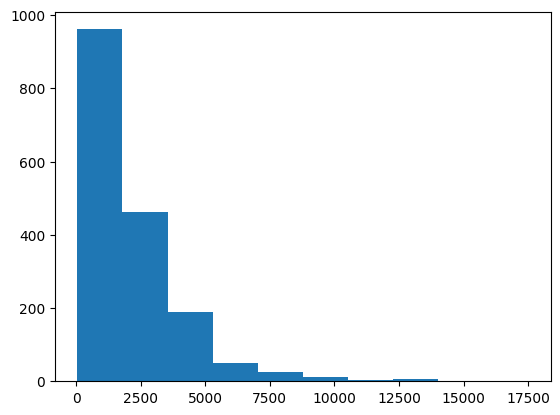

In [26]:
#Plotting short time energy distribution histogram of all chunks
energy = np.array([sum(abs(vid[i:i+window_length]**2)) for i in range(0, len(vid), window_length)])
plt.hist(energy) 
plt.show()
#Close graphs for progress of program

In [27]:
energy

array([2112.42873386, 2336.9132881 , 2016.92829494, ..., 2824.79192217,
       2372.94416373,  788.54579263])

In [44]:
#Finding and setting threshold value of commentator and audience noise above which we want to include portion in highlights.
df=pd.DataFrame(columns=['energy','start','end'])
thresh=800 #Find deviation point for energy threshold
row_index=0
for i in range(len(energy)):
	value=energy[i]
	if(value>=thresh):
		i=np.where(energy == value)[0]
		df.loc[row_index,'energy']=value
		df.loc[row_index,'start']=i[0] * 5
		df.loc[row_index,'end']=(i[0]+1) * 5
		row_index= row_index + 1

In [41]:
df

,energy,start,end
0,2112.428734,0,5
1,2336.913288,5,10
2,2016.928295,10,15
3,2127.57538,15,20
4,2007.29402,20,25
...,...,...,...
1188,2596.553923,8505,8510
1189,3804.394029,8510,8515
1190,2611.560443,8515,8520
1191,2824.791922,8520,8525


In [45]:
#Merge consecutive time intervals of audio clips into one.
temp=[]
i,j,n=0,0,len(df) - 1
while(i<n):
	j=i+1
	while(j<=n):
		if(df['end'][i] == df['start'][j]):
			df.loc[i,'end'] = df.loc[j,'end']
			temp.append(j)
			j=j+1
		else:
			i=j
			break  
df.drop(temp,axis=0,inplace=True)

In [46]:
df

,energy,start,end
0,2112.428734,0,40
8,1044.512526,45,65
12,1467.128781,150,165
15,943.890538,170,350
51,1052.050248,360,370
...,...,...,...
1142,2684.653063,7975,8025
1152,1721.353602,8030,8035
1153,2474.3503,8040,8275
1200,2444.133079,8280,8395


In [47]:
#Extracting subclips from the video file on the basis of energy profile obtained from audio file.
start=np.array(df['start'])
end=np.array(df['end'])

In [48]:
df['start']

0          0
8         45
12       150
15       170
51       360
        ... 
1142    7975
1152    8030
1153    8040
1200    8280
1223    8400
Name: start, Length: 129, dtype: object

In [49]:
df['end']

0         40
8         65
12       165
15       350
51       370
        ... 
1142    8025
1152    8035
1153    8275
1200    8395
1223    8530
Name: end, Length: 129, dtype: object

In [51]:
#Create temporary folder for storing subclips generated. This folder will be deleted later after highlights are generated. 
sub_folder=os.path.join(ETC_DIR,"Subclips")
if os.path.exists(sub_folder):
	shutil.rmtree(sub_folder)
	path=os.mkdir(sub_folder)
else:
	path=os.mkdir(sub_folder)
#print(sub_folder,type(sub_folder))

In [52]:
#Extract moments from videos to be added in highlight
print(df)
for i in range(len(df)):
	if(i!=0):
		start_lim = start[i] - 5  #Assuming that noise starts after the shot, so set start point as t-5 seconds to include the shot/wicket action.
	else:
		start_lim = start[i] 
	end_lim   = end[i]   
	filename="highlight" + str(i+1) + ".mp4"
	ffmpeg_extract_subclip(SAMPLES_DIR+VIDEO_NAME,start_lim,end_lim,targetname=sub_folder+"/"+filename) #Enter your sports video clip name here.

           energy start   end
0     2112.428734     0    40
8     1044.512526    45    65
12    1467.128781   150   165
15     943.890538   170   350
51    1052.050248   360   370
...           ...   ...   ...
1142  2684.653063  7975  8025
1152  1721.353602  8030  8035
1153    2474.3503  8040  8275
1200  2444.133079  8280  8395
1223   817.658194  8400  8530

[129 rows x 3 columns]
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command succes

In [53]:
files=os.listdir(sub_folder)
files=[sub_folder+"/highlight" + str(i+1) + ".mp4" for i in range(len(df))]
#print(files)
final_clip=concatenate_videoclips([VideoFileClip(i) for i in files])
final_clip.write_videofile(OUT_DIR+VIDEO_NAME) #Enter the desired output highlights filename.
shutil.rmtree(sub_folder) #Delete the temporary file.